In [9]:
import pandas as pd
from pathlib import Path

In [12]:
DATA_PATH = Path("/content/amazonreviews.tsv")

In [13]:
df = pd.read_csv(DATA_PATH, sep="\t", quoting=3, on_bad_lines="skip")

In [14]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nValue counts for 'label':\n", df['label'].value_counts(dropna=False))
print("\nMissing values per column:\n", df.isna().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())

Shape: (10000, 2)
Columns: ['label', 'review']

Value counts for 'label':
 label
neg    5097
pos    4903
Name: count, dtype: int64

Missing values per column:
 label     0
review    0
dtype: int64

Number of duplicate rows: 0


DATA CLEANING

In [15]:
# Drop duplicates
df = df.drop_duplicates()

# Standardize label values
df['label'] = df['label'].astype(str).str.strip().str.lower()
df['label'] = df['label'].map({'pos':'pos','neg':'neg'})

# Drop blank reviews if any
blank_reviews = (df['review'].astype(str).str.strip() == '')
df = df[~blank_reviews].copy()

print("Final shape after cleaning:", df.shape)
print("Labels after cleaning:\n", df['label'].value_counts())


Final shape after cleaning: (10000, 2)
Labels after cleaning:
 label
neg    5097
pos    4903
Name: count, dtype: int64


Text Preprocessing

In [16]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords

stop_words = set(sklearn_stopwords)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)       # remove urls
    text = re.sub(r'[^a-z\s]', ' ', text)               # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

# Apply cleaning
df['clean_review'] = df['review'].astype(str).map(preprocess_text)

# Show some samples
print(df[['review','clean_review']].head())


                                              review  \
0  Stuning even for the non-gamer: This sound tra...   
1  The best soundtrack ever to anything.: I'm rea...   
2  "Amazing!: This soundtrack is my favorite musi...   
3  Excellent Soundtrack: I truly like this soundt...   
4  Remember, Pull Your Jaw Off The Floor After He...   

                                        clean_review  
0  stuning non gamer sound track beautiful paints...  
1  best soundtrack reading lot reviews saying bes...  
2  amazing soundtrack favorite music time hands i...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull jaw floor hearing ve played game...  


Exploratory Analysis

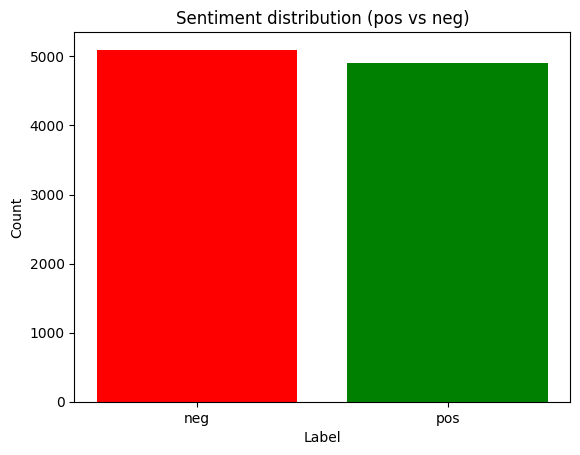

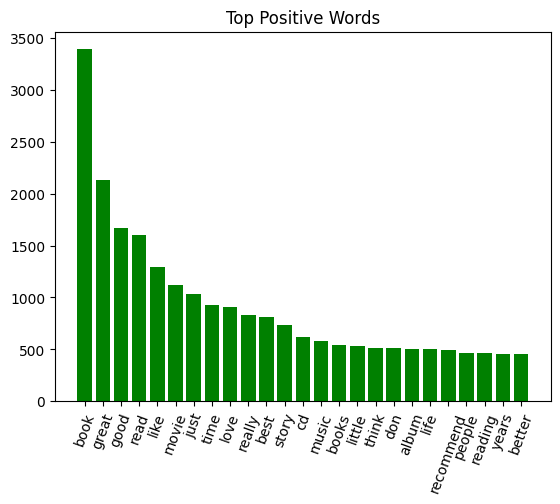

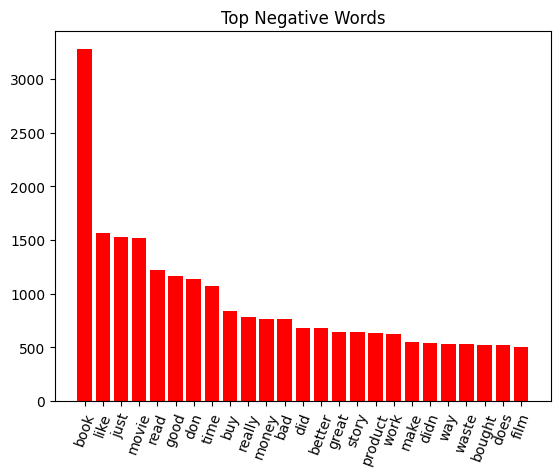

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Sentiment distribution
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color=['red','green'])
plt.title("Sentiment distribution (pos vs neg)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Top words
pos_text = " ".join(df.loc[df['label']=='pos', 'clean_review'])
neg_text = " ".join(df.loc[df['label']=='neg', 'clean_review'])

pos_counter = Counter(pos_text.split())
neg_counter = Counter(neg_text.split())

# Plot top 25 positive
pos_top = pos_counter.most_common(25)
plt.bar([w for w,c in pos_top], [c for w,c in pos_top], color="green")
plt.xticks(rotation=70)
plt.title("Top Positive Words")
plt.show()

# Plot top 25 negative
neg_top = neg_counter.most_common(25)
plt.bar([w for w,c in neg_top], [c for w,c in neg_top], color="red")
plt.xticks(rotation=70)
plt.title("Top Negative Words")
plt.show()


Feature Extraction & Model training(Logistic Regression)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1019
           1       0.86      0.84      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



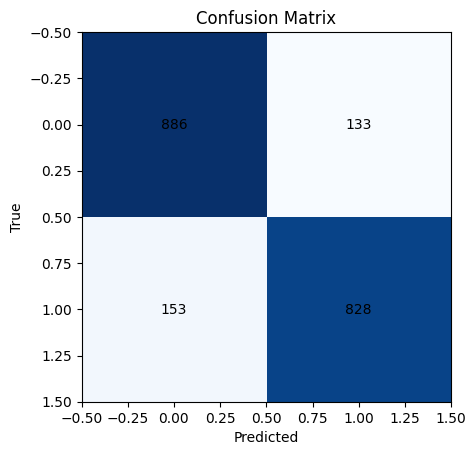

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Split
X = df['clean_review']
y = df['label'].map({'pos':1, 'neg':0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()


Cross-Validation (Model Comparison)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=3)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=3)),
    ('clf', LinearSVC(max_iter=5000))
])

scores_lr = cross_val_score(pipe_lr, X, y, cv=5, scoring='accuracy')
scores_svc = cross_val_score(pipe_svc, X, y, cv=5, scoring='accuracy')

print("Logistic Regression CV Mean:", scores_lr.mean())
print("Linear SVC CV Mean:", scores_svc.mean())


Logistic Regression CV Mean: 0.8411000000000002
Linear SVC CV Mean: 0.8356999999999999
